# Deep Learning HW2

Gerald Baulig 0780827 2019/12/02

GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we were asked to implement a Convolutional Neural Network (CNN) from scratch.
The CNN has to be demonstrated on two datasets:

1. The MNIST dataset of handwritten digits, and
2. The CIFAR-10 dataset with tiny images of 10 different classes.

# A CNN from Scratch

In contrast to the fully-connected layers which apply an inner product of the weight matrices, a 2D convolutional layer applies a kernel convolution onto the input and is therewith a sparse connected layer.

Most challening is to decide a shape convention of the input, output and weight matrices.
In this project we shape our matrices as follows:
    (number of samples, height, width, channels)

## Smart Indexing

A kernel could be described as a filter that slides pixelwise over the input and accumulates the pixel region to one pixel of the output matrix.

However, if we did implement the kernel convolution straight forward following the mathematical description, then we would get lost in deep interleaved for-loops and the backpropagation would bother even more.
It is much easier to convert the kernel convolution to a common matrix multiplication by using the so-called Toeplitz matrix.
In this approach the kernels and the input get unfolded to a 2D-matrice.
Each kernel becomes a vector and w.r.t each kernel, we arrange an input-vector.

Thank's to numpys phonotonic array indexing, it is convenitent to impl. a function that creates indices according to the input shape, the kernel shape and the striding:

In [1]:
import numpy as np
import numpy.matlib

def indices(xs, ks, stride=(1,1)):
    '''
    Create indices that shapes a Toeplitz matrix.
    
    The shapes are espected as follows:
        (number of samples, height, width, channels)
        or
        (height, width, channels)
        or
        (height, width)
    
    Args:
        xs: The input shape
        ks: The kernel shape
        stride: A tuple with the step sizes for the sliding window
    Returns:
        n: Indices along the number of inputs
        v: Indices along the input height
        u: Indices along the input width
        c: Indices along the input channels
        shape: The target shape
    '''
    if len(ks) is 4:
        kn, kv, ku, kc = ks
    elif len(ks) is 3:
        kv, ku, kc = ks
        kn = 1
    elif len(ks) is 2:
        kv, ku = ks
        kc = 1
        kn = 1
        pass
    
    if len(xs) is 4:
        xn, xv, xu, xc = xs
    elif len(xs) is 3:
        xv, xu, xc = xs
        xn = 1
    elif len(xs) is 2:
        xv, xu = xs
        xn = 1
        xc = 1
        pass
        
    sv, su = stride
    
    def base(u, k, s):
        u = u+1-k
        K = np.arange(0, k)
        U = np.arange(0, u, s)
        us = U.size
        i = np.tile(K, us).reshape(us, k) + np.repeat(U, k).reshape(us, k)
        return i
    
    u = base(xu, ku, su)
    if xv is xu and kv is ku:
        v = u.copy()
    else:
        v = base(xv, kv, sv)
    
    shape = (max(v.shape[0],1), max(u.shape[0],1))
    u = np.matlib.repmat(u, shape[0], kv*xc*xn).T
    v = np.matlib.repmat(v, 1, ku)
    v = np.repeat(v, shape[1], axis=0)
    v = np.repeat(v, xc, axis=1).T
    v = np.matlib.repmat(v, xn, 1)
    
    n = np.repeat(np.arange(xn), kv*ku*xc)[:,None] if xn > 1 else 0
    v = v if len(v) else 0
    u = u if len(u) else 0
    c = np.tile(np.repeat(np.arange(xc), kv*ku), xn)[:,None] if xc > 1 else 0
    return n, v, u, c, shape

## Test
def test_Indices():
    r = np.reshape(np.arange(5*5), (5,5))
    print("R: ", r.shape, "\n", r)
    n, v, u, c, shape = indices((1,5,5,1),(1,3,3,1),(1,1))
    print("U: ", u.shape, "\n", u)
    print("V: ", v.shape, "\n", v)
    r = r[v, u]
    print("R': ", r.shape, "\n", r)
test_Indices()

R:  (5, 5) 
 [[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
U:  (9, 9) 
 [[0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]
 [0 1 2 0 1 2 0 1 2]
 [1 2 3 1 2 3 1 2 3]
 [2 3 4 2 3 4 2 3 4]]
V:  (9, 9) 
 [[0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]
 [0 0 0 1 1 1 2 2 2]
 [1 1 1 2 2 2 3 3 3]
 [2 2 2 3 3 3 4 4 4]]
R':  (9, 9) 
 [[ 0  1  2  5  6  7 10 11 12]
 [ 6  7  8 11 12 13 16 17 18]
 [12 13 14 17 18 19 22 23 24]
 [ 0  1  2  5  6  7 10 11 12]
 [ 6  7  8 11 12 13 16 17 18]
 [12 13 14 17 18 19 22 23 24]
 [ 0  1  2  5  6  7 10 11 12]
 [ 6  7  8 11 12 13 16 17 18]
 [12 13 14 17 18 19 22 23 24]]


## Padding

I'm not a fan of padding.
In 2D image processing, there is no plausibility for padding, unless the image is a 360-degree panorama, but if so, it should be wraping.
On the other hand, padding is also used to keep the dimensions of the feature-maps constant.
However, since we are interested in shrinking down the feature map to a 1D-hot-vector, I see no use for padding.

Nevertheless, the following function shows how we could perform a zero-padding:

In [19]:
import numpy as np

def padding(X, pad=(0,1,1,0)):
    '''
    Alignes a zero filled padding boarder on X
    
    Args:
        X: The input-matrix with shape (n,v,u,c)
        pad: The padding extensions for (n,v,u,c) 
    '''
    if len(pad) is 4:
        pn, pv, pu, pc = pad
    elif len(pad) is 3:
        pn = 0
        pv, pu, pc = pad
    elif len(pad) is 2:
        pn, pc = (0, 0)
        pv, pu = pad
    pad = (pn,pv,pu,pc)
    shape = np.array(X.shape, dtype=int) + np.array(pad)*2
    Xp = np.zeros(shape)
    Xp[pn:shape[0]-pn,pv:shape[1]-pv,pu:shape[2]-pu,pc:shape[3]-pc] = X
    return Xp

## Test
def test_padding():
    Xp = padding(np.ones((1,5,5,1)), (0,1,1,0))
    print(np.squeeze(Xp))
test_padding()

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


## The Kernel Convolution

The core function of out CNN.
Since HW1, we modified the Layer class such that it is no longer required to to inherit this class and implement the pull_forward and push_backward function. Instead we can set a FeedFunction at the Layer initialization, which could either be a InnerProduct for a fully-connected layer or a Conv2D for 2D-convolution sparse layer.

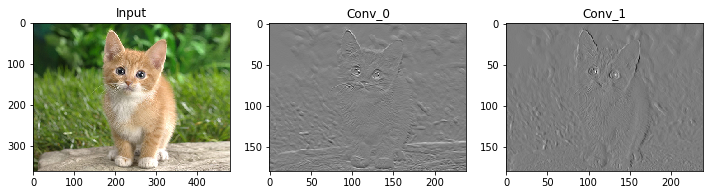

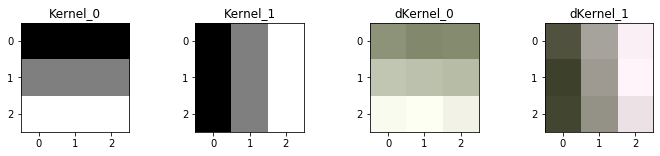

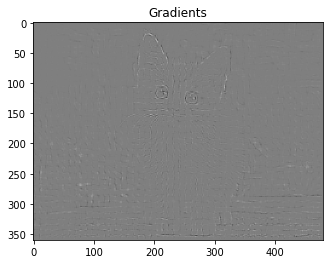

In [3]:
import numpy as np
from mynn import FeedFunc

def shape_nvuc(arr):
    '''
    Reshapes the array to the expected 4D-matrix
    
    Glosar:
        n = num of samples
        v = height
        u = width
        c = channels
        
    4dim will be interpreted as (n,v,u,c). Output stays the same.
    3dim will be interpreted as (v,u,c) and modified to (1,v,u,c)
    2dim will be interpreted as (v,u) and modified to (1,v,u,1)
    
    Args:
        arr: The array to be reshaped
    Returns:
        
    '''
    if arr.ndim is 4:
        pass
    elif arr.ndim is 2:
        arr = arr[None,:,:,None,]
    elif arr.ndim is 3:
        arr = arr[None,:]
    else:
        raise ValueError("Matrix should have atleast 2dims!")
    return arr, np.array(arr.shape, dtype=int)

class Conv2D(FeedFunc):
    '''
    A Feed-Forward-Function that performs a 2D kernel convolution.
    
    Assign an instance of this class to a Layer, such that it becomes a
    sparse convolution layer.
    '''
    
    def __init__(self, stride=(1,1), pad=None):
        '''
        Initialize a 2D Convolution Function.
        
        Args:
            stride: The step size of the sliding kernel, default: (1,1)
            pad: Apply a pedding onto the input, default: None
        '''
        self.stride = stride
        self.uptodate = False
        self.pad = pad
        pass
    
    def f(self, X, K):
        '''
        The feed forward function.
        
        Args:
            X: The input-matrix (n,v,u,c)
            K: The kernels (n,v,u,c)
        Returns:
            Y: The convolved matrix.
        '''
        X, xs = shape_nvuc(X)
        K, ks = shape_nvuc(K)
        if self.pad:
            X = padding(X, pad)
        
        if self.uptodate:
            self.uptodate = xs is self.xs and ks is self.ks
            pass
        
        if not self.uptodate:
            self.xs = xs
            self.ks = ks
            self.uptodate = True
            _, self.v, self.u, self.c, self.shape = indices(xs[1:], ks[1:], self.stride)
            K = K.transpose(0,3,1,2)
            self.ws = K.shape
            self.K = K.reshape(ks[0],-1)
            self.ys = (xs[0], xs[3], xs[1], xs[2])
            pass
        
        self.X = X[:,self.v,self.u,self.c].reshape(self.K.shape[1], -1)
        Y = np.dot(self.K, self.X)
        Y = Y.reshape(self.xs[0], -1, self.shape[0], self.shape[1])
        return Y.transpose(0,2,3,1)
    
    def dw(self, _X, dZ):
        '''
        Derivative for the kernel weights.
        
        Args:
            _X: Deprecated! Cached X will be used.
            dZ: The gradients of the previous Layer.
        Returns:
            dW: The gradients for W
        '''
        self.dZ = dZ.transpose(0,3,1,2).reshape(-1, self.X.shape[1])
        dW = np.dot(self.dZ, self.X.T)
        dW = dW.reshape(self.ws)
        return dW.transpose(0,2,3,1)
    
    def dy(self, _dZ, _K):
        '''
        The derivative of this convolution.
        
        Args:
            All args are deprecated.
            Cached values will be used.
        Returns:
            The gradients for the underlying Layer.
        '''
        y = np.dot(self.K.T, self.dZ) 
        y = y.reshape(self.xs[0], np.prod(self.ks[1:]), -1)
        dY = np.zeros(self.ys)
        np.add.at(
            dY,
            (slice(None), self.c, self.v, self.u),
            y
        )
        return dY.transpose(0,2,3,1)
    
    def db(self, dZ):
        '''
        The derivative for the bias.
        
        Args:
            dZ: The gradients of the upper Layer
        Returns:
            db: The gradients for bias
        '''
        return dZ.sum(axis=(0,1,2))

##test
def cam_ready(x):
    '''
    Preperates the matrix for an image plot.
    '''
    x = np.squeeze(x)
    return x / np.abs(x).max() * 0.5 + 0.5

def test_Conv2D():
    %matplotlib inline
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('kitty.jpg'), dtype=float) / 255
    k = np.zeros((2,3,3,3)) ##create 2 3*3kernels with 3 channels
    k[0,0,:] = -1.
    k[0,2,:] = 1. ##horz. haar line filter
    k[1,:,0] = -1.
    k[1,:,2] = 1. ##vert. filter

    conv = Conv2D((2,2))
    y = conv.f(x, k)
    dw = conv.dw(x, y)
    dY = conv.dy(y, k)

    ## viz
    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,3)
    ax[0].set_title("Input")
    ax[0].imshow(x)
    
    for i, a in enumerate(ax[1:]):
        a.set_title("Conv_{}".format(i))
        a.imshow(cam_ready(y[0,:,:,i]), cmap='gray')
    plt.show()
    
    results = (k[0],k[1],dw[0],dw[1])
    titles = ("Kernel_0", "Kernel_1", "dKernel_0", "dKernel_1")
    fig = plt.figure(figsize=(12,2))
    ax = fig.subplots(1,4)
    for i, a in enumerate(ax):
        a.set_title(titles[i])
        a.imshow(cam_ready(results[i]))
    plt.show()
    
    plt.title("Gradients")
    plt.imshow(cam_ready(dY[0]))
    plt.show()
    
test_Conv2D()

## Max Pooling

Max Pooling is a computational cheap tool to shrink the feature-maps.
Since we have the indices, and the image matrix is unfolded,
we can simple take the max of each row and we cache the argmax for the backprob.

We implement MaxPooling with a 'pull_forward' and 'push_backward' function.
However we do not inherit Layer, because MaxPooling has no trainable parameters.

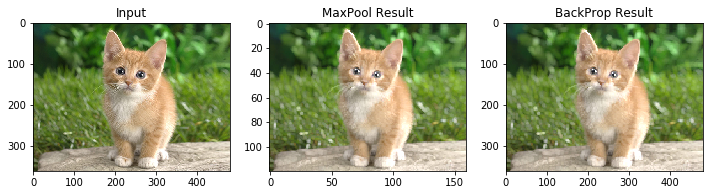

In [4]:
import numpy as np

class MaxPooling():
    '''
    Performs a feature-mep reduction by taking the max responses.
    MaxPooling can be used likewise a Layer,
    but however not trainable and will not be stored in a model dump.
    '''
    
    def __init__(self,
                 indices,
                 input_func,
                 backprop
                ):
        '''
        Initialize a MaxPooling Layer.
        
        Args:
            indices: The indices w.r.t input-shape and kernel-shape
            input_func: The input generater function of an underlying layer.
            backprop: The push_backward function of an underlying layer.
        '''
        self.input = input_func
        self.backprop = backprop
        _, self.v, self.u, self.c, self.shape = indices
        pass
    
    def pull_forward(self):
        '''
        Takes the max activation potentials of the kernel region.
        
        Returns:
            A reshaped matrix of (n,v,u,c)
        '''
        for x in self.input():
            self.xs = x.shape
            x = x[:,self.v,self.u]
            ys = (self.xs[0], self.shape[0], self.shape[1], -1)
            self.z = np.argmax(x, axis=1).reshape(self.xs[0], -1)
            yield np.max(x, axis=1).reshape(ys)
        pass
    
    def push_backward(self, dZ, lr):
        '''
        Propagates the gradients to the maxima of the underlying Layer.
        The maxima are cached from latest push_forward call.
        
        Args:
            dZ: The gradients of the upper layer.
            lr: The learning-rate
        '''
        dx = np.zeros(self.xs)
        dZ = dZ.reshape(dZ.shape[0], -1, dZ.shape[-1])
        for i, x in enumerate(dx):
            np.add.at(
                x,
                (self.v, self.u),
                dZ[i]
            )
        if self.backprop:
            self.backprop(dx, lr)
        else:
            return dx, lr

## Test
def test_MaxPool():
    import matplotlib.pylab as plt
    from PIL import Image
    
    x = np.asarray(Image.open('kitty.jpg'), dtype=float) / 255
    x, xs = shape_nvuc(x)
    def gen_Lenna():
         yield x
    
    mp = MaxPooling(
        indices=indices(xs,(1,3,3,1),(3,3)),
        input_func=gen_Lenna,
        backprop=None
    )
    
    for Y in mp.pull_forward():
        pass
    
    dZ, _ = shape_nvuc(Y)
    dX, _ = mp.push_backward(dZ,0)
    
    results = (x, Y, dX/3.0)
    titles = ("Input", "MaxPool Result", "BackProp Result")
    fig = plt.figure(figsize=(12,4))
    ax = fig.subplots(1,3)
    for i, a in enumerate(ax):
        a.set_title(titles[i])
        a.imshow(np.squeeze(results[i]), cmap='gray')
    plt.show()
    pass

test_MaxPool()

## Reshape Layer

Similar to the Max Pooling Layer the Reshape Layer alows us to change the dimensions of the feature-map,
i.e. for reshaping the feature-map to a 1D-vector, such that fully-connected layers can proceed.
However, transformations that we perform forward must get undone backward.

In [5]:
import numpy as np

class Reshape():
    def __init__(self,
                 input_func,
                 backprop,
                 forward_shape,
                 backward_shape
                ):
        '''
        Initialize a Reshape Layer.
        
        Args:
            input_func: Feed Forward generator of the underlying layer.
            backprop: Backprop function of the underlying layer.
            forward_shape: The target shape for feed forward.
            backward_shape: The target shape for the backprop.
        '''
        self.input = input_func
        self.backprop = backprop
        self.forward_shape = forward_shape
        self.backward_shape = backward_shape
        pass
    
    def pull_forward(self):
        for x in self.input():
            yield x.reshape(self.forward_shape)
        pass
    
    def push_backward(self, dZ, lr):
        if self.backprop:
            self.backprop(dZ.reshape(self.backward_shape), lr)
        else:
            return dZ.reshape(self.backward_shape), lr

# 1. A CNN for MINIST

## Load n Prepare the MNIST Dataset

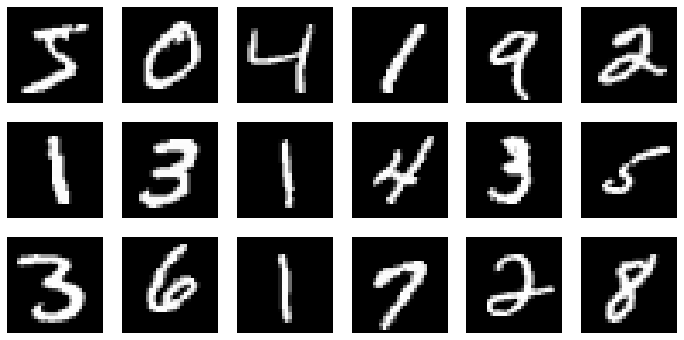

Labels: [5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8]
Input shape: (18, 28, 28, 1)


In [6]:
import numpy as np

def gen_UBYTES_data(filename, batch_size=1, split=1.0, norm=True, preload=False):
    '''
    Creates a data generator from a MNIST UBYTE file.
    Reads the header and yields according data samples.
    
    Args:
        filename: A path string to the file to be loaded.
        batch_size: How many sampels to be yields per iteration.
        split: A float -1..0..1,
            negative for keeping the trailing part
            positive for keeping the leading part
        norm: Whether the data should be normalized to 1.0
        preload: Whether all data should be loaded to the memory.
            Otherwise reads batch-wise
    Yields:
        Yields data samples in according to the batch_size.
    '''
    
    #read header
    with open(filename, 'rb') as fid:
        mag = int.from_bytes(fid.read(4), byteorder='big')
        N = int.from_bytes(fid.read(4), byteorder='big')
        if mag == 2051:
            row = int.from_bytes(fid.read(4), byteorder='big')
            col = int.from_bytes(fid.read(4), byteorder='big')
        else:
            row = 1
            col = 1
        payload = fid.tell()
    
    #split
    if split > 0:
        N0 = 0
        N = int(N * split)
    else:
        N0 = N + int(N * split)
    
    #read payload batch wise
    trail = 0
    total = N - N0
    if preload:
        with open(filename, 'rb') as fid:
            fid.seek(payload)
            batch = fid.read(N*row*col)
            pass
        
        batch = np.frombuffer(batch, dtype=np.uint8)
        if mag == 2051:
            if norm:
                batch = batch.astype(float) / 255
            batch = np.reshape(batch, (N, row, col, 1))
            
        for n in range(N0,N,batch_size):
            samples = batch_size - (n % batch_size)
            trail += samples
            yield batch[n:n+samples], trail, total
    else:
        for n in range(N0,N,batch_size):
            with open(filename, 'rb') as fid:
                fid.seek(payload+n)
                batch = fid.read(batch_size*row*col)
                pass

            batch = np.frombuffer(batch, dtype=np.uint8)
            samples = batch_size - (n % batch_size)
            trail += samples
            if mag == 2051:
                if norm:
                    batch = batch.astype(float) / 255
                batch = np.reshape(batch, (samples, row, col, 1))
            yield batch, trail, total
    pass

def to_hot_vector(labels, k):
    '''
    Transforms a vector of id labels to a zero filled hot-vector.
    
    Args:
        labels: The id vector.
        k: The number of classes.
    Returns:
        The hot-vector (n,k)
    '''
    N = labels.shape[0] if len(labels.shape) else 1
    hot = np.zeros((N, k))
    hot[range(N),labels] = 1
    return hot

def gen_MNIST_data(
    data="train-images.idx3-ubyte",
    labels="train-labels.idx1-ubyte",
    batch_size=1,
    split = 1.0,
    norm=True,
    preload=False,
):
    '''
    Generates data samples and lables in parallel.
    
    Args:
        data: The file path to the handwritten digits.
        labels: The file path to the labels.
        batch_size: How many sample per yield.
        split: See gen_UBYTES_data
        norm: Whether to normalize the images.
        preload: Whether to preload the images.
            The labels get preloaded anyway.
    '''
    gen_data = gen_UBYTES_data(data, batch_size, split, norm, preload)
    gen_labels = gen_UBYTES_data(labels, batch_size, split, norm, True)
    for data, label in zip(gen_data, gen_labels):
        X = data[0]
        T = to_hot_vector(label[0], 10)
        trail = data[1]
        total = data[2]
        yield X, T, trail, total

## test
def test_get_MNIST_data():
    %matplotlib inline
    import matplotlib.pylab as plt
    fig = plt.figure(figsize=(12,6))
    ax = fig.subplots(3,6)
    ax = np.reshape(ax, 6*3)

    ## get one batch and break
    for X, T, _, _ in gen_MNIST_data(
        "train-images.idx3-ubyte",
        "train-labels.idx1-ubyte",
        batch_size=6*3,
        norm=False
    ):
        for i, sample in enumerate(X):
            ax[i].set_axis_off()
            ax[i].imshow(np.squeeze(sample), cmap='gray')
        break
    plt.show()
    print("Labels:", np.where(T)[1])
    print("Input shape:", X.shape)
test_get_MNIST_data()

## Configure CNN for MNIST


In [7]:
import numpy as np
from mynn import (
    NeuralNetwork,
    Layer,
    InnerProduct,
    CrossEntropy,
    ArgMaxPooling,
    ReLU,
    Sigmoid
)

def init_params(c, u, v, n, bias=True, init_func=np.random.randn):
    '''Initialize parameters.
    
    Args:
        c: Number of channels of the kernel
        u, v: shape of the kernel.
        n: Number of kernels.
        bias: True, if a bias should be used, otherwise False.
        init_func: Alter the initialization function.
            (default) np.random.randn
    Returns:
        kernels: A 4-dimensional matrix of weights.
        bias: Either 0 or a vector of biases for each node.
    '''
    kernels = init_func(n, v, u, c)
    return kernels, np.zeros(n) if bias else 0

def init_MNIST_cnn(batch_size):
    '''
    Initialize 2 Conv2D layers, 1 Reshape Layer and 1 FcLayer.
    '''
    cnn = NeuralNetwork(
        train_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            batch_size,
            split=0.8
        ),
        val_set = lambda: gen_MNIST_data(
            "train-images.idx3-ubyte",
            "train-labels.idx1-ubyte",
            batch_size,
            split=-0.2
        ),
        cost_func=CrossEntropy,
        loss_func=ArgMaxPooling
    )
    
    cnn.In = Layer(
        params=init_params(1,5,5,10),
        feed_func=Conv2D(stride=(3,3)),
        input_func=cnn.gen_input,
        backprop=None,
        act_func = ReLU
    ) #(28-4)/3=8
    
    # consumes to much memory
    #cnn.MaxPool1 = MaxPooling(
    #    indices=indices((26,26,10),(1,3,3,1),(2,2)),
    #    input_func=cnn.In.pull_forward,
    #    backprop=cnn.In.push_backward
    #) #(26-2)/2=12
    
    cnn.Conv1 = Layer(
        params=init_params(10,3,3,10),
        feed_func=Conv2D(stride=(2,2)),
        input_func=cnn.In.pull_forward,
        backprop=cnn.In.push_backward,
        act_func = ReLU
    ) #(8-2)/2=3
    
    cnn.Reshape1 = Reshape(
        input_func=cnn.Conv1.pull_forward,
        backprop=cnn.Conv1.push_backward,
        forward_shape=(-1,90),
        backward_shape=(-1,3,3,10)
    ) # (n,3,3,10) <-> (n,90)
    
    cnn.Out = Layer(
        params=InnerProduct.init_params(90,10),
        feed_func=InnerProduct,
        input_func=cnn.Reshape1.pull_forward,
        backprop=cnn.Reshape1.push_backward,
        act_func = Sigmoid(100)
    ) #90 <-> 10
    return cnn

cnn = init_MNIST_cnn(1)

## Train CNN for MNIST

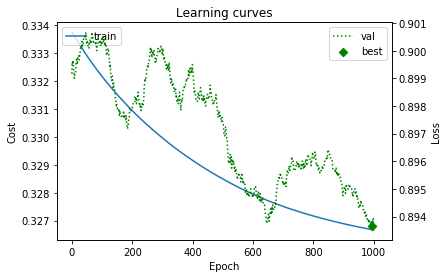

Best Epoch: 994 with a Loss of: 0.8936666666666666


(994, 0.8936666666666666)

In [12]:
from mynn.Tools import train_n_plot
from mynn import load

np.random.seed(1)
epochs = 1000
batch_size = 6000
lr = 1e-5
lr_dec = 1e-10
model_name = "mnist_cnn"
ckpts = 10

cnn = init_MNIST_cnn(batch_size)
load(cnn, "mnist_cnn_best.pkl")

train_n_plot(cnn, epochs, lr, lr_dec, model_name, ckpts)

# Conclusion

